# Face Morph Animation

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import imageio

## Configuration

In [2]:
data_dir = Path('../../data')
results_dir = Path('../../results/face_matching')
results_dir.mkdir(parents=True, exist_ok=True)

N_FRAMES = 30
FPS = 10

## Load Images

In [3]:
image1_path = data_dir / 'CelebAMask-HQ/CelebA-HQ-img/7.jpg'
image2_path = data_dir / 'CelebAMask-HQ/CelebA-HQ-img/169.jpg'

img1 = cv2.imread(str(image1_path))
img2 = cv2.imread(str(image2_path))

if img1 is None or img2 is None:
    raise ValueError('Could not load images')

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

height, width = img1.shape[:2]
img2_rgb = cv2.resize(img2_rgb, (width, height))
img2 = cv2.resize(img2, (width, height))

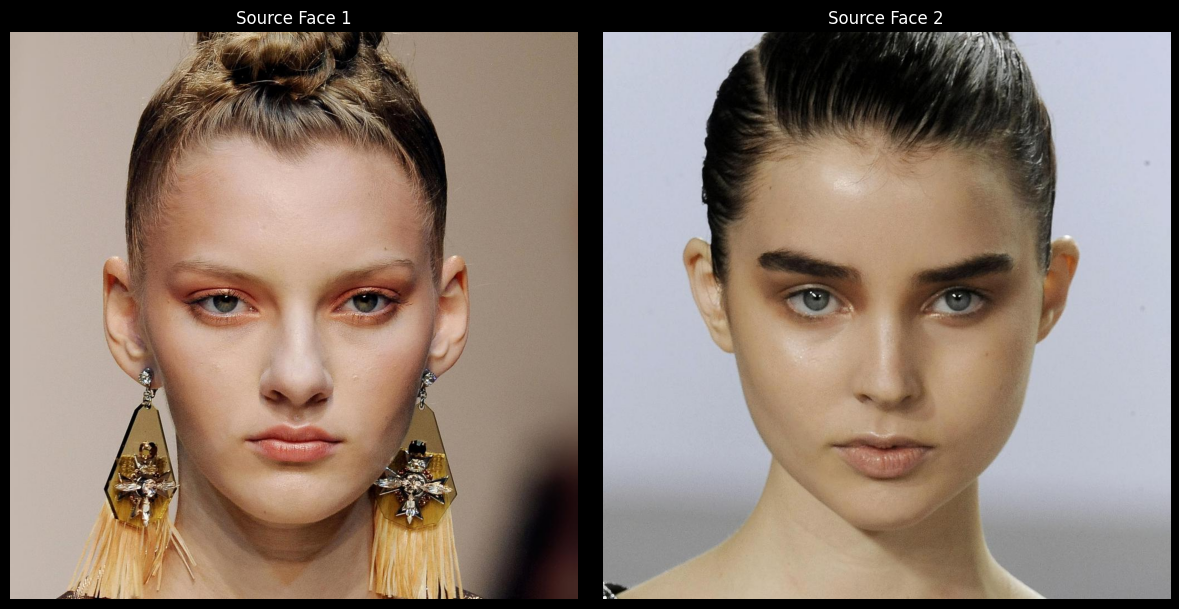

In [4]:
# Display source images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1_rgb)
axes[0].set_title('Source Face 1')
axes[0].axis('off')
axes[1].imshow(img2_rgb)
axes[1].set_title('Source Face 2')
axes[1].axis('off')
plt.tight_layout()
plt.savefig(results_dir / 'morph_source_images.png', dpi=150, bbox_inches='tight')
plt.show()

## Extract Landmarks

In [5]:
def extract_landmarks(image_rgb):
    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5
    ) as face_mesh:
        results = face_mesh.process(image_rgb)
        if not results.multi_face_landmarks:
            raise ValueError('No face detected')
        face_landmarks = results.multi_face_landmarks[0]
        h, w = image_rgb.shape[:2]
        landmarks = []
        for landmark in face_landmarks.landmark:
            x = int(landmark.x * w)
            y = int(landmark.y * h)
            landmarks.append([x, y])
        return np.array(landmarks, dtype=np.float32)

In [6]:
landmarks1 = extract_landmarks(img1_rgb)
landmarks2 = extract_landmarks(img2_rgb)

print(f'Extracted {len(landmarks1)} landmarks from each image')

Extracted 478 landmarks from each image


I0000 00:00:1765930723.446548   75538 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765930723.499558   75702 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 570.195.03), renderer: NVIDIA GeForce RTX 5070 Ti/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765930723.505615   75688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765930723.515036   75699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765930723.516992   75686 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
I0000 00:00:1765930723.536204   75538 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


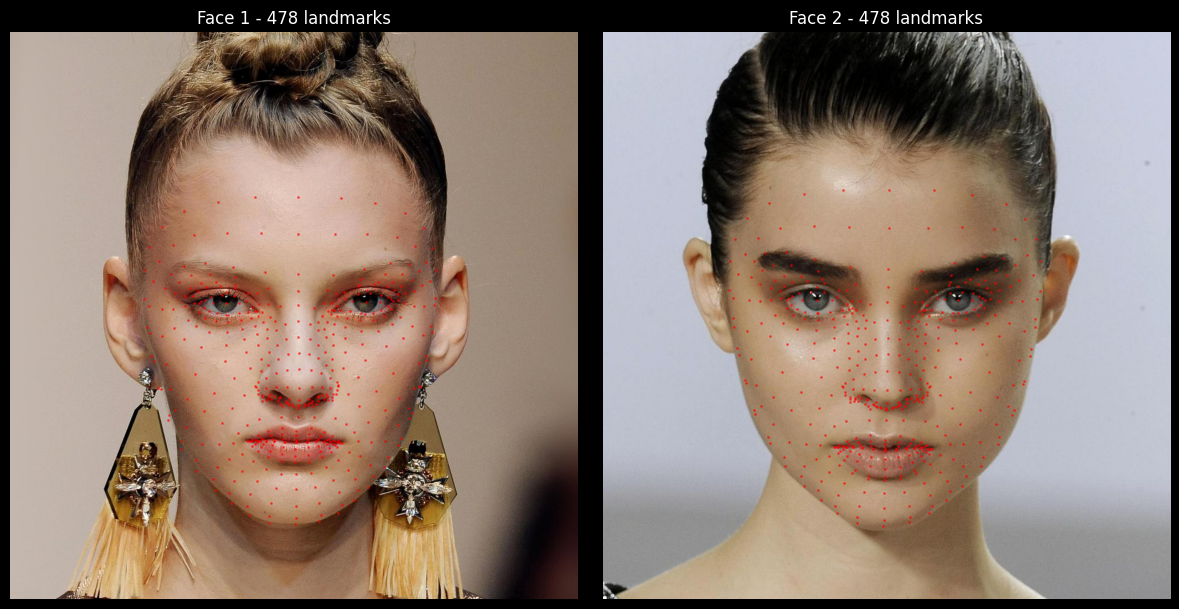

In [7]:
# Visualize landmarks
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1_rgb)
axes[0].scatter(landmarks1[:, 0], landmarks1[:, 1], c='red', s=1, alpha=0.5)
axes[0].set_title(f'Face 1 - {len(landmarks1)} landmarks')
axes[0].axis('off')

axes[1].imshow(img2_rgb)
axes[1].scatter(landmarks2[:, 0], landmarks2[:, 1], c='red', s=1, alpha=0.5)
axes[1].set_title(f'Face 2 - {len(landmarks2)} landmarks')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(results_dir / 'morph_landmarks.png', dpi=150, bbox_inches='tight')
plt.show()

## Delaunay Triangulation

In [8]:
def compute_delaunay_triangulation(landmarks, img_shape):
    h, w = img_shape[:2]
    corners = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32)
    points = np.vstack([landmarks, corners])
    rect = (0, 0, w, h)
    subdiv = cv2.Subdiv2D(rect)
    for point in points:
        subdiv.insert((float(point[0]), float(point[1])))
    triangles = subdiv.getTriangleList()
    triangle_indices = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        indices = []
        for pt in [pt1, pt2, pt3]:
            for i, p in enumerate(points):
                if abs(p[0] - pt[0]) < 1.0 and abs(p[1] - pt[1]) < 1.0:
                    indices.append(i)
                    break
        if len(indices) == 3:
            triangle_indices.append(indices)
    return points, np.array(triangle_indices)

In [9]:
avg_landmarks = (landmarks1 + landmarks2) / 2.0
points, triangles = compute_delaunay_triangulation(avg_landmarks, img1_rgb.shape)

print(f'Total points: {len(points)}, Triangles: {len(triangles)}')

Total points: 482, Triangles: 956


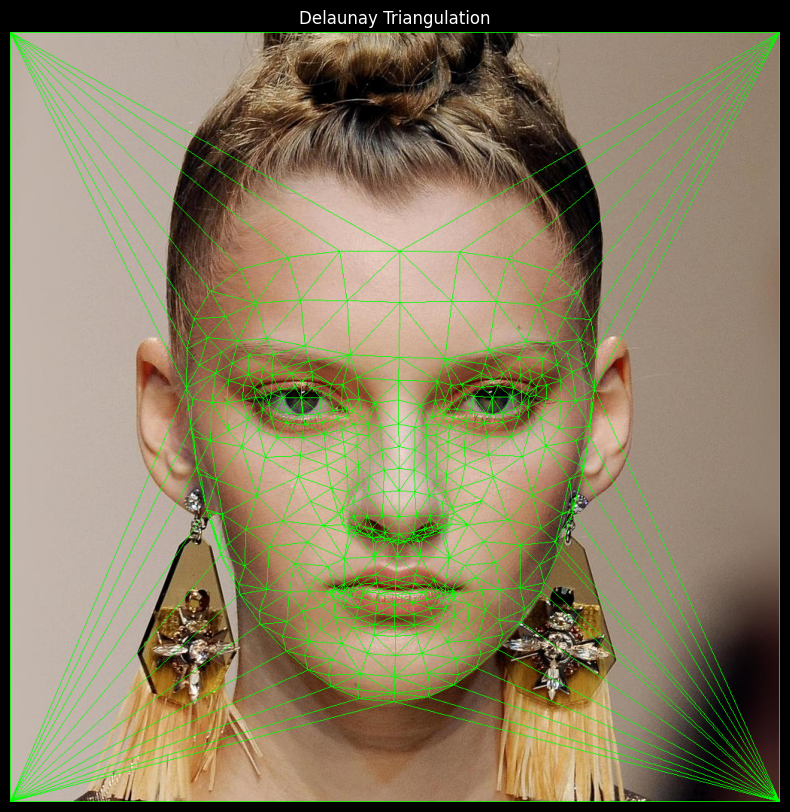

In [10]:
# Visualize triangulation
def draw_triangulation(image, points, triangles):
    img_tri = image.copy()
    for tri in triangles:
        pt1 = tuple(points[tri[0]].astype(int))
        pt2 = tuple(points[tri[1]].astype(int))
        pt3 = tuple(points[tri[2]].astype(int))
        cv2.line(img_tri, pt1, pt2, (0, 255, 0), 1)
        cv2.line(img_tri, pt2, pt3, (0, 255, 0), 1)
        cv2.line(img_tri, pt3, pt1, (0, 255, 0), 1)
    return img_tri

img_tri = draw_triangulation(img1_rgb, points, triangles)

plt.figure(figsize=(10, 10))
plt.imshow(img_tri)
plt.title('Delaunay Triangulation')
plt.axis('off')
plt.savefig(results_dir / 'morph_triangulation.png', dpi=150, bbox_inches='tight')
plt.show()

## Warping Functions

In [11]:
def affine_transform_triangle(src_img, src_tri, dst_tri, size):
    """
    Warp a triangle from src_img to a destination triangle.
    """
    # Get bounding rectangles
    src_rect = cv2.boundingRect(src_tri)
    dst_rect = cv2.boundingRect(dst_tri)
    
    # Offset points by top-left corner of bounding box
    src_tri_cropped = []
    dst_tri_cropped = []
    
    for i in range(3):
        src_tri_cropped.append((
            src_tri[i][0] - src_rect[0],
            src_tri[i][1] - src_rect[1]
        ))
        dst_tri_cropped.append((
            dst_tri[i][0] - dst_rect[0],
            dst_tri[i][1] - dst_rect[1]
        ))
    
    # Crop input image
    src_cropped = src_img[
        src_rect[1]:src_rect[1] + src_rect[3],
        src_rect[0]:src_rect[0] + src_rect[2]
    ]
    
    # Calculate affine transform
    warp_mat = cv2.getAffineTransform(
        np.float32(src_tri_cropped),
        np.float32(dst_tri_cropped)
    )
    
    # Warp the cropped triangle
    dst_cropped = cv2.warpAffine(
        src_cropped,
        warp_mat,
        (dst_rect[2], dst_rect[3]),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REFLECT_101
    )
    
    # Create mask for triangle
    mask = np.zeros((dst_rect[3], dst_rect[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(dst_tri_cropped), (1.0, 1.0, 1.0))
    
    # Apply mask and copy to output image
    dst_cropped = dst_cropped * mask
    
    return dst_cropped, dst_rect, mask


def morph_triangle(img1, img2, img_morph, src_tri1, src_tri2, dst_tri, alpha):
    """
    Morph a single triangle from two source images to a destination.
    alpha controls the blend: 0 = img1, 1 = img2
    """
    # Warp triangles from both images
    dst_cropped1, dst_rect1, mask1 = affine_transform_triangle(
        img1, src_tri1, dst_tri, img_morph.shape
    )
    dst_cropped2, dst_rect2, mask2 = affine_transform_triangle(
        img2, src_tri2, dst_tri, img_morph.shape
    )
    
    # Blend the two warped triangles
    dst_cropped = (1.0 - alpha) * dst_cropped1 + alpha * dst_cropped2
    
    # Copy to output image
    img_morph[
        dst_rect1[1]:dst_rect1[1] + dst_rect1[3],
        dst_rect1[0]:dst_rect1[0] + dst_rect1[2]
    ] = (
        img_morph[
            dst_rect1[1]:dst_rect1[1] + dst_rect1[3],
            dst_rect1[0]:dst_rect1[0] + dst_rect1[2]
        ] * (1 - mask1) + dst_cropped
    )

## Generate Morph Animation

In [12]:
def morph_faces(img1, img2, landmarks1, landmarks2, triangles, alpha):
    """
    Create a morphed image at interpolation parameter alpha.
    alpha = 0: full img1, alpha = 1: full img2
    """
    # Add corners to landmarks
    h, w = img1.shape[:2]
    corners = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32)
    
    points1 = np.vstack([landmarks1, corners])
    points2 = np.vstack([landmarks2, corners])
    
    # Interpolate landmarks
    points_morph = (1.0 - alpha) * points1 + alpha * points2
    
    # Initialize output image
    img_morph = np.zeros_like(img1, dtype=np.float32)
    
    # Warp each triangle
    for tri_indices in triangles:
        src_tri1 = points1[tri_indices].astype(np.float32)
        src_tri2 = points2[tri_indices].astype(np.float32)
        dst_tri = points_morph[tri_indices].astype(np.float32)
        
        morph_triangle(
            img1.astype(np.float32),
            img2.astype(np.float32),
            img_morph,
            src_tri1,
            src_tri2,
            dst_tri,
            alpha
        )
    
    return np.clip(img_morph, 0, 255).astype(np.uint8)

In [13]:
print(f'Generating {N_FRAMES} morph frames...')

morph_frames = []
alphas = np.linspace(0, 1, N_FRAMES)

for i, alpha in enumerate(alphas):
    print(f'Frame {i+1}/{N_FRAMES} (alpha={alpha:.3f})', end='\r')
    morphed_img = morph_faces(img1_rgb, img2_rgb, landmarks1, landmarks2, triangles, alpha)
    morph_frames.append(morphed_img)

print('\nDone!')

Generating 30 morph frames...
Frame 30/30 (alpha=1.000)
Done!


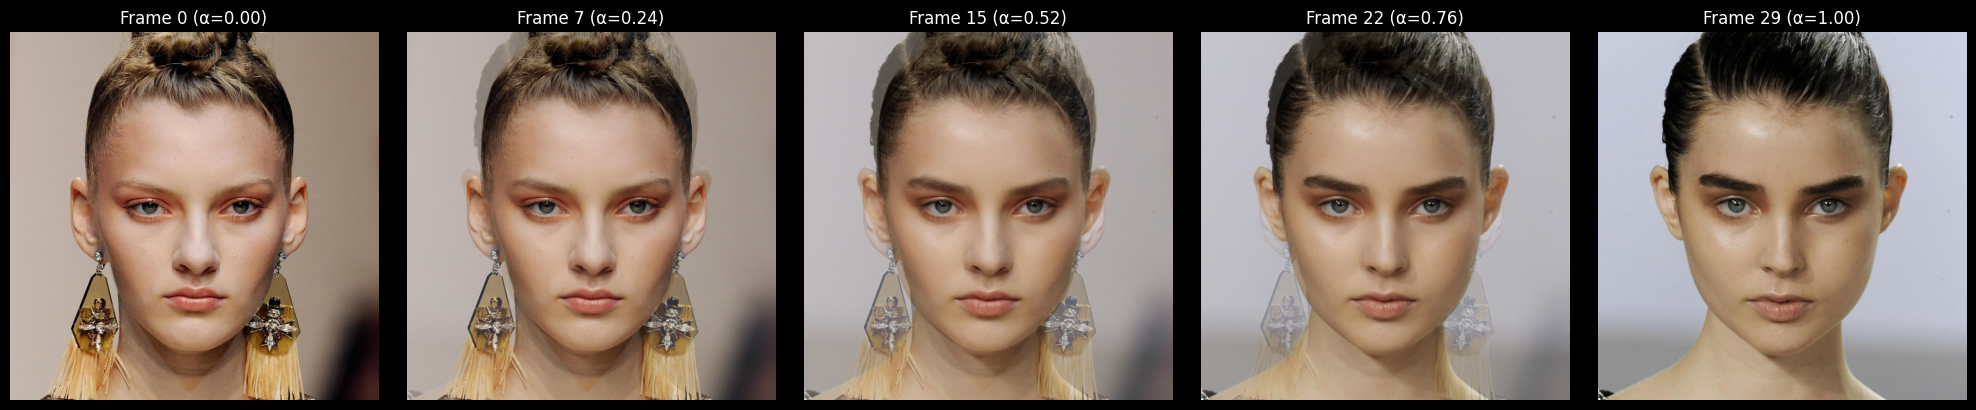

In [14]:
# Display sample frames
sample_indices = [0, N_FRAMES//4, N_FRAMES//2, 3*N_FRAMES//4, N_FRAMES-1]
sample_alphas = [alphas[i] for i in sample_indices]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, (i, alpha) in enumerate(zip(sample_indices, sample_alphas)):
    axes[idx].imshow(morph_frames[i])
    axes[idx].set_title(f'Frame {i} (α={alpha:.2f})')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(results_dir / 'morph_sample_frames.png', dpi=150, bbox_inches='tight')
plt.show()

## Export Animation

In [15]:
gif_path = results_dir / 'face_morph.gif'
imageio.mimsave(gif_path, morph_frames, fps=FPS, loop=0)
print(f'Saved GIF to {gif_path}')

mp4_path = results_dir / 'face_morph.mp4'
try:
    writer = imageio.get_writer(mp4_path, fps=FPS, codec='libx264', quality=8)
    for frame in morph_frames:
        writer.append_data(frame)
    writer.close()
    print(f'Saved MP4 to {mp4_path}')
except Exception as e:
    print(f'MP4 export failed: {e}')

Saved GIF to ../../results/face_matching/face_morph.gif
Saved MP4 to ../../results/face_matching/face_morph.mp4


### Summary

Face morphing using MediaPipe landmarks and Delaunay triangulation successfully generates smooth transitions between two faces. The algorithm extracts 478 dense landmarks, computes triangulation on 482 points (including 4 corners), resulting in 956 triangles. Each frame interpolates landmark positions with parameter α, warps both source images using affine transforms, and blends the results. Generating 30 frames creates a smooth morph animation demonstrating MediaPipe's superiority for face applications that require dense semantic correspondence.